In [24]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    merge_experiment_metadata,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_8 import (
    dataset_dir,
    input_shape,
)

save_metadata_dir = "outputs/metadata/experiment_8_0/"
save_output_dir = "outputs/raw_data/experiment_8_0/"

from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

# run once
# merged_experiment_metadata = merge_experiment_metadata(save_metadata_dir=save_metadata_dir, glob_path="experiment_8_*/merged_*.csv")

In [27]:
project_metadata = load_experiment_metadata(save_metadata_dir, glob_path="merged_*.csv")
project_metadata.drop_duplicates(inplace=True)
print(project_metadata.columns)
project_metadata = project_metadata.dropna().set_index(
    [
        "image_index",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)

Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'dataset', 'image_index', 'image_path', 'input_shape', 'num_classes',
       'seed', 'batch_size', 'max_batches', 'min_change',
       'metadata_file_path'],
      dtype='object')
(8016, 26)


In [28]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
image_indices = project_metadata.index.get_level_values("image_index").unique()

image_index  alpha_mask_value
7907         0.0                 3
9904         0.0                 3
3002         0.1                 3
1306         0.0                 3
307          0.0                 3
                                ..
3305         0.2                 2
             0.3                 2
3306         0.0                 2
             0.1                 2
9909         0.3                 2
Name: count, Length: 4000, dtype: int64
4000


In [19]:
project_metadata.iloc[0]

time_to_compute                                                        9.833506
batch_index                                                                   2
monitored_statistic_change                                                  0.0
path_prefix                                              0202_090856599940-8440
data_path                     /home/x_amime/x_amime/projects/an_explanation_...
stream_name                                                           log_probs
stream_statistic                                                          meanx
alpha_mask_type                                                          static
baseline_mask_type                                                     gaussian
projection_type                                                      prediction
projection_distribution                                                   delta
projection_top_k                                                              1
projection_index                        

In [20]:
frequencies = project_metadata.index.get_level_values("alpha_mask_value").unique()
frequencies

Index([0.0, 0.1, 0.2, 0.3], dtype='float64', name='alpha_mask_value')

In [10]:
preds_temp = project_metadata["data_path"].apply(lambda y: np.load(y))

FileNotFoundError: [Errno 2] No such file or directory: '/home/x_amime/x_amime/projects/an_explanation_model/outputs/raw_data/experiment_8_0/2024-01-16_22-11-57-321301.log_probs.meanx.npy'

In [ ]:
temp = preds_temp.apply(lambda x: np.argmax(x))
temp.name = "preds"
temp = pd.concat([temp, project_metadata["label"]], axis=1)
temp = (
    temp.apply(lambda x: x["preds"] == x["label"], axis=1)
    .groupby("alpha_mask_value")
    .mean()
)
temp.plot()

In [45]:
temp.name = "Accuracy"
temp.to_csv("outputs/processed/accuracyatnoise.csv")

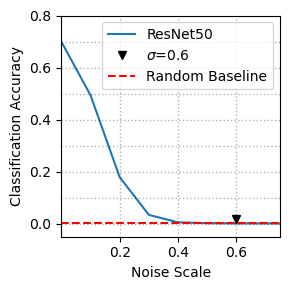

In [7]:
temp = pd.read_csv("outputs/processed/accuracyatnoise.csv")
plt.figure(figsize=(3, 3))
plt.plot(temp["alpha_mask_value"], temp["Accuracy"], label="ResNet50")
plt.xlabel("Noise Scale")
plt.xlim(0, 0.75)
ticks = [0.2, 0.4, 0.6]
plt.xticks(ticks)
for nscale in ticks:
    plt.axvline(
        nscale,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
accs = plt.yticks()[0]
for acc in accs:
    plt.axhline(
        acc,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
plt.ylim(-0.05, 0.8)
# plt.vlines(0.6, 0, 1, linestyles="dashed", colors="k", label=r"$\sigma$=0.6")
# place a dot at 0.6 and 0 
plt.plot([0.6], [0.02], 'v', color='black', label=r"$\sigma$=0.6")
plt.ylabel("Classification Accuracy")
plt.hlines(0.001, 0, 1, linestyles="dashed", colors="red", label="Random Baseline")
plt.tight_layout()
plt.legend()
plt.savefig("outputs/figures/accuracyatnoise.pdf")

In [60]:
temp

,alpha_mask_value,Accuracy
0,0.0,0.698883
1,0.1,0.493247
2,0.2,0.178798
3,0.3,0.033946
4,0.4,0.005305
5,0.5,0.002010
6,0.6,0.001166
7,0.7,0.000985
8,0.8,0.000985
9,0.9,0.000945


In [61]:
temp.to_latex("outputs/processed/accuracy_at_noise.tex", float_format="%.5f")

In [11]:
temp = preds_temp.apply(lambda x: -np.sum(x * np.exp(x)))
temp.name = "entropy"
temp = temp.groupby("alpha_mask_value").mean()

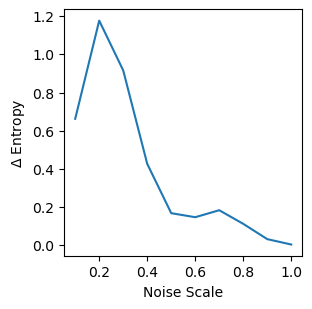

In [26]:
plt.figure(figsize=(3, 3))
delta_entropy = temp.diff()
delta_entropy = delta_entropy.dropna()
delta_entropy.to_csv("outputs/processed/delta_entropy.csv")
plt.plot(delta_entropy.index, delta_entropy)
plt.tight_layout()
plt.xlabel("Noise Scale")
plt.ylabel(r"$\Delta$ Entropy")
plt.savefig("outputs/figures/delta_entropy.pdf")

In [29]:
temp2

,alpha_mask_value,entropy
0,0.1,0.662645
1,0.2,1.176966
2,0.3,0.916214
3,0.4,0.426577
4,0.5,0.168109
5,0.6,0.147022
6,0.7,0.183619
7,0.8,0.112199
8,0.9,0.032145
9,1.0,0.003867


/tmp/ipykernel_1938883/1127975830.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/tmp/ipykernel_1938883/1127975830.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


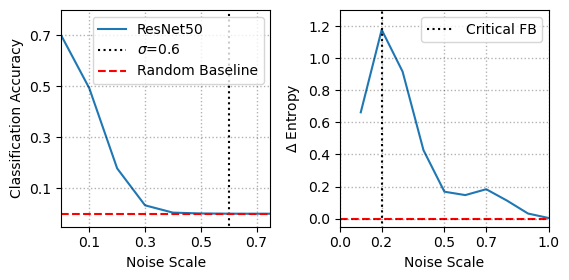

In [9]:
temp1 = pd.read_csv("outputs/processed/accuracyatnoise.csv")
temp2 = pd.read_csv("outputs/processed/delta_entropy.csv")
u=5.8
plt.subplots(figsize=(u, u/2))
plt.subplot(1, 2, 1)
plt.plot(temp1["alpha_mask_value"], temp1["Accuracy"], label="ResNet50")
plt.xlabel("Noise Scale")
plt.xlim(0, 0.75)
plt.ylim(-0.05, 0.8)
plt.xticks([0.1, 0.3, 0.5, 0.7])
plt.yticks([0.1, 0.3, 0.5, .7])
xticks = plt.xticks()[0]
yticks = plt.yticks()[0]
for nscale in xticks:
    plt.axvline(
        nscale,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
for acc in yticks:
    plt.axhline(
        acc,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
plt.vlines(0.6, -1, 1.5, linestyles=":", colors="k", label=r"$\sigma$=0.6")
plt.ylabel("Classification Accuracy")
plt.hlines(0.001, 0, 1, linestyles="dashed", colors="red", label="Random Baseline")
plt.tight_layout()
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(temp2["alpha_mask_value"], temp2["entropy"]) #label="ResNet50"
plt.xlabel("Noise Scale")
plt.xticks([0.0, 0.2, 0.5,0.7, 1.0])
plt.ylim(-0.05, 1.3)
plt.xlim(0, 1)
plt.vlines(0.2, -0.2, 1.5, linestyles=":", colors="black", label="Critical FB")
plt.ylabel(r"$\Delta$ Entropy")
plt.hlines(0, 0, 1, linestyles="dashed", colors="red") # label="Random Baseline"

xticks = plt.xticks()[0]
yticks = plt.yticks()[0]
for nscale in xticks:
    plt.axvline(
        nscale,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
for acc in yticks:
    plt.axhline(
        acc,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
plt.tight_layout()
plt.legend()
plt.savefig("outputs/figures/accuracy_entropy_at_noise.pdf")

/tmp/ipykernel_1938883/968761979.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)
/tmp/ipykernel_1938883/968761979.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


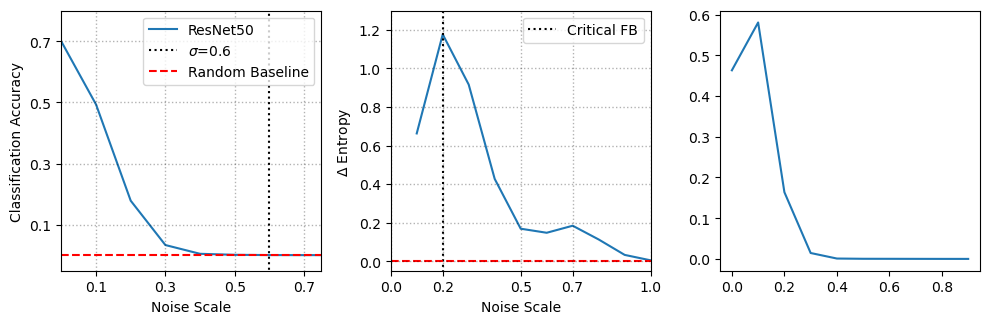

In [31]:
temp1 = pd.read_csv("outputs/processed/accuracyatnoise.csv")
temp2 = pd.read_csv("outputs/processed/delta_entropy.csv")
u=10
plt.subplots(figsize=(u, u/3))
plt.subplot(1, 3, 1)
plt.plot(temp1["alpha_mask_value"], temp1["Accuracy"], label="ResNet50")
plt.xlabel("Noise Scale")
plt.xlim(0, 0.75)
plt.ylim(-0.05, 0.8)
plt.xticks([0.1, 0.3, 0.5, 0.7])
plt.yticks([0.1, 0.3, 0.5, .7])
xticks = plt.xticks()[0]
yticks = plt.yticks()[0]
for nscale in xticks:
    plt.axvline(
        nscale,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
for acc in yticks:
    plt.axhline(
        acc,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
plt.vlines(0.6, -1, 1.5, linestyles=":", colors="k", label=r"$\sigma$=0.6")
plt.ylabel("Classification Accuracy")
plt.hlines(0.001, 0, 1, linestyles="dashed", colors="red", label="Random Baseline")
plt.tight_layout()
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(temp2["alpha_mask_value"], temp2["entropy"]) #label="ResNet50"
plt.xlabel("Noise Scale")
plt.xticks([0.0, 0.2, 0.5,0.7, 1.0])
plt.ylim(-0.05, 1.3)
plt.xlim(0, 1)
plt.vlines(0.2, -0.2, 1.5, linestyles=":", colors="black", label="Critical FB")
plt.ylabel(r"$\Delta$ Entropy")
plt.hlines(0, 0, 1, linestyles="dashed", colors="red") # label="Random Baseline"

xticks = plt.xticks()[0]
yticks = plt.yticks()[0]
for nscale in xticks:
    plt.axvline(
        nscale,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
for acc in yticks:
    plt.axhline(
        acc,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )
plt.tight_layout()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(temp1["alpha_mask_value"], temp1["Accuracy"]*temp2["entropy"], label="ResNet50")

plt.savefig("outputs/figures/accuracy_entropy_at_noise.pdf")

<Axes: xlabel='alpha_mask_value'>

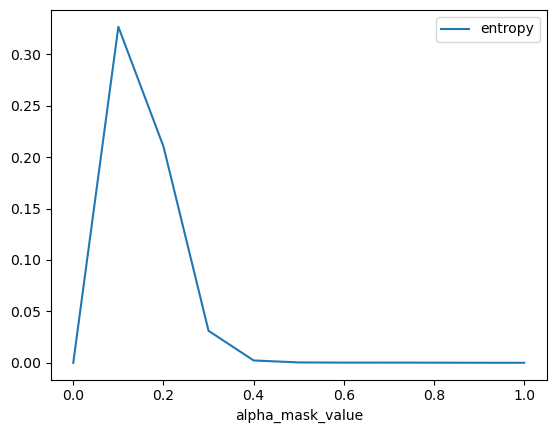

In [41]:
row = pd.DataFrame({"alpha_mask_value": 0, "entropy": 0}, index=[0])
temp3 = pd.concat(
    [row, temp2], axis=0
).reset_index(drop=True)
temp3["entropy"] = temp3["entropy"]*temp1["Accuracy"]
temp3.plot(x="alpha_mask_value", y="entropy")